# Neural Model - Learning Mechanism with Prior Information

In [1]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

In this notebook we present a first implementation of a neural model for sound source elevation estimation based on the computational HRTF model. 

**TODO**



In [3]:
# Import necessary modules
from pathlib import Path
from src.data import generateData
from src.features import helpers as hp
from src.visualization import helpers as hpVis
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
from scipy.ndimage import gaussian_filter1d,convolve1d
from scipy.signal import convolve2d
from IPython import display
from scipy.spatial import distance

hpVis.set_layout(15)


ROOT = Path(os.getcwd()).resolve().parents[0]

SOUND_FILES = ROOT / 'data/raw/sound_samples/'
# create a list of the sound files
SOUND_FILES = list(SOUND_FILES.glob('**/*.wav'))


class LinearReg():

    def __init__(self, x, y):
        from sklearn.linear_model import LinearRegression

        self.lr_model = LinearRegression()

        self.x = x.reshape(-1, 1)
        self.y = y.reshape(-1, 1)

        self.lr_model.fit(self.x, self.y)

        self.rr = self.lr_model.score(self.x, self.y)

    def get_fitted_line(self):
        return [self.x, self.lr_model.predict(self.x)]

    def get_coefficients(self):
        return self.lr_model.coef_[0, 0], self.lr_model.intercept_[0]

    def get_score(self, x=0, y=0):
        if x == 0 or y == 0:
            return self.rr
        else:
            return self.lr_model.score(x, y)

    def print_coefficients(self):
        print('Gain: {0:1.2f}, Bias: {1:1.2f}, , r^2: {2:1.2f}'.format(self.lr_model.coef_[0, 0], self.lr_model.intercept_[0], self.rr))
        return ('Gain: {0:1.2f},\nBias: {1:1.2f},\n' + r'$r^2$: {2:1.2f}').format(self.lr_model.coef_[0, 0], self.lr_model.intercept_[0], self.rr)





In [4]:
############################################################
#                  Simulation functions                    #
############################################################

tau = 0.005

# Defines the output transfer function of q_A_SC 
def out_thres(q,threshold = 0.0,slope=1):    
    return np.minimum(np.maximum((q-threshold)*slope,0),1)

   
# Defines the sigmoidal transfer function  
def out_sigmoid(x,slope =5,operation_point=0.0):
#     return 1 / (1 + np.exp(-(x-working_point)*slope) ) 
    tmp = (x-operation_point)*slope
    return (2 / (1 + np.exp(-4*tmp**2)))-1


#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        tmp = np.exp(-(x-mean)**2 /( 2 * sigma**2 ))
        return tmp/np.max(tmp)
    
# define the ODE for inhibitory input neurons
def ode_p_in(p ,excitatory_in):
 # tau defines how fast the membrane potential builds up
#     tau = 1.0
    # alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
    alpha=1
    # beta defines the upper limit of the membrane potential
    beta= 1
    
    # calculate the change of r_Alearn
    d_p  = -alpha *p  + (beta -p )*excitatory_in
    
    return d_p /tau 

# define the ODE for gaussian filter neurons
def ode_r_in(r,excitatory_in,inhibitory_in):
    # tau defines how fast the membrane potential builds up
#     tau = 1.0
    # alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
    alpha= 1
    # beta defines the upper limit of the membrane potential
    beta= 200
    # gamma defines the subtractive influence of the inhibitory input
    gamma = 0.0
    # kappa defines the divisive influence of the inhibitory input
    kappa = 200
    
    # calculate the change of r_Alearn
    d_r  = -alpha  * r * excitatory_in  + (beta -r ) * excitatory_in  - (gamma  + kappa  * r ) * inhibitory_in
    
    return d_r / tau


# define the ODE for neuron p_sum
def ode_p_sum(p ,excitatory_in):
 # tau defines how fast the membrane potential builds up
#     tau = 1
    # alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
    alpha= 1
    # beta defines the upper limit of the membrane potential
    beta= 1
    
    # calculate the change of r_Alearn
    d_p  = -alpha *p  + (beta -p )*excitatory_in
    
    return d_p /tau 

# define the ODE for integration neurons
def ode_r(r,excitatory_in,inhibitory_in=0):
    # tau defines how fast the membrane potential builds up
#     tau = 1
    # alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
    alpha= 1
    # beta defines the upper limit of the membrane potential
    beta= 2
    # gamma defines the subtractive influence of the inhibitory input
    gamma = 0
    # kappa defines the divisive influence of the inhibitory input
    kappa = 1
    
    # calculate the change of r_Alearn
    d_r  = -alpha  * r * excitatory_in   + (beta -r ) * excitatory_in  - (gamma  + kappa  * r ) * inhibitory_in
    
    return d_r /tau

# define the ODE for read out neurons
def ode_q_sum(q ,excitatory_in):
 # tau defines how fast the membrane potential builds up
#     tau = 1
    # alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
    alpha= 1
    # beta defines the upper limit of the membrane potential
    beta= 1
    
    # calculate the change of r_Alearn
    d_q  = -alpha *q  + (beta -q )*excitatory_in
    
    return d_q /tau 


# define the ODE for read out neurons
def ode_q_fin(q ,excitatory_in):
 # tau defines how fast the membrane potential builds up
#     tau = 1
    # alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
    alpha= 1
    # beta defines the upper limit of the membrane potential
    beta= 1
    
    # calculate the change of r_Alearn
    d_q  = -alpha *q   + (beta -q )*excitatory_in
    
    return d_q /tau 


### Parameters

In [5]:
########################################################################
######################## Set parameters ################################
########################################################################
azimuth = 12
snr = 0.0
freq_bands = 128
participant_number = 8

normalize = False
time_window = 0.1  # time window in sec

# filtering parameters
normalization_type = 'sum_1'
sigma_smoothing = 0
sigma_gauss_norm = 1

# use the mean subtracted map as the learned map
mean_subtracted_map = True

ear = 'ipsi'

elevations = np.arange(0, 25, 1)


############################################################
#                  Simulation parameter                    #
############################################################

# Time step
dt = 0.0001 # -> 

# Solve differential equation from time 0 to time T
T = 0.3# 
# Descretize time into equal steps
ts = np.linspace (0 , T , int ( T / dt )+1)


### Simulation

In [54]:
#generate inputs
psd_all_c, psd_all_i = generateData.create_data(freq_bands, participant_number, snr, normalize, azimuth, time_window)

# Take only given elevations
input_c = psd_all_c[:, elevations, :]
input_i = psd_all_i[:, elevations, :]

# normalize inputs over frequencies
input_c = input_c / input_c.sum(2)[:,:,np.newaxis]
input_i = input_i / input_i.sum(2)[:,:,np.newaxis]

# Define neurons
# sound_types = np.array([0,4,6,9,10])
sound_types = np.arange(0,20)
# sound_types = np.array([0])

n_sounds = len(sound_types)
# elevations_angles = np.array([0])
elevations_angles = np.arange(0,25,1)
n_elevations = len(elevations_angles)

sigma = 3


r_steady = np.zeros((n_sounds,freq_bands,len(ts)-1))
q_steady = np.zeros((n_sounds,len(elevations),len(ts)))

x_kernel = np.arange(freq_bands)

gauss_kernel = gauss(np.arange(-4*sigma,4*sigma),0,sigma)


# weight initialization
# w = np.zeros((freq_bands,elevations)) 
# w = np.random.random_sample((len(ts)*len(sound_types)*len(elevations_angles),len(elevations),freq_bands)) * 1
w = np.random.random_sample((len(elevations),freq_bands)) * 0.1

w_sounds = np.random.random_sample((n_sounds,len(elevations),freq_bands)) * 0.1

# time step for weights
t_w = 0

# learning rate
learning_rate = 0.00005


for i_sound,sound in enumerate(sound_types):
    for i_ele,ele in enumerate(elevations_angles):
        
#         ele = np.random.randint(0,25)
#         sound = np.random.choice(sound_types)

        
        in_i = input_i[sound,ele]
        in_c = input_c[sound,ele]

        # since the input does not change over time. We can do this calculation ouside the loop
        excitatory_in_p_i = convolve1d(out_thres(in_i),weights=gauss_kernel,axis=0,mode='reflect')
        excitatory_in_p_c = convolve1d(out_thres(in_c),weights=gauss_kernel,axis=0,mode='reflect')
        
        # visual guidance signal TODO
        v_in = np.zeros((len(elevations),1))
        v_in[ele] = 1 
        
        p_in_c = np.zeros((len(ts),freq_bands))
        p_in_i = np.zeros((len(ts),freq_bands))

        r_in_c = np.zeros((len(ts),freq_bands))
        r_in_i = np.zeros((len(ts),freq_bands))

        p_sum_i = np.zeros((len(ts),freq_bands))
        p_sum_c = np.zeros((len(ts),freq_bands))
        r_ipsi = np.zeros((len(ts),freq_bands))
        q_ele = np.zeros((len(ts),len(elevations)))


        for t in range(0,len(ts)-1):
            
            
            ## p_In_ipsi neuron
            # feed inputs ipsi inhibition
            p_in_i[t+1,:] = p_in_i[ t,:] + dt* ode_p_in(p_in_i[t,:],excitatory_in_p_i)  

            ## r_In_ipsi neuron
            excitatory_in = out_thres(in_i)
            inhibitory_in = out_thres(p_in_i[ t,:])
            r_in_i[ t+1,:] = r_in_i[t,:] + dt* ode_r_in(r_in_i[t,:],excitatory_in,inhibitory_in)   

            ## p_In_contra neuron
            # feed inputs ipsi inhibition
            p_in_c[ t+1,:] = p_in_c[ t,:] + dt* ode_p_in(p_in_c[t,:],excitatory_in_p_c)  

            ## r_In_contra neuron
            excitatory_in = out_thres(in_c)
            inhibitory_in = out_thres(p_in_c[ t,:])
            r_in_c[t+1,:] = r_in_c[t,:] + dt* ode_r_in(r_in_c[t,:],excitatory_in,inhibitory_in)   

            
            ## p_sum neurons
            excitatory_in = out_thres(r_in_i[ t,:]) 
            p_sum_i[ t+1,:] = p_sum_i[ t,:] + dt* ode_p_sum( p_sum_i[ t,:],excitatory_in)   
            
            excitatory_in = out_thres(r_in_c[ t,:]) 
            p_sum_c[ t+1,:] = p_sum_c[ t,:] + dt* ode_p_sum(p_sum_c[ t,:],excitatory_in)   
            
            
            ## r_ipsi neuron
            excitatory_in = out_thres(r_in_i[t,:])
            inhibitory_in =  out_thres(p_sum_c[ t,:]) + out_thres(p_sum_i[ t,:])
            r_ipsi[t+1,:] = r_ipsi[t,:] + dt* ode_r(r_ipsi[t,:],excitatory_in,inhibitory_in)   
            
            ## q readout neurons
            excitatory_in = np.sum(r_ipsi[t,:] * w[:,:],axis=1)
            q_ele[t+1,:] = q_ele[t,:]+ dt* ode_q_sum(q_ele[t,:],excitatory_in)   
                      
            
            # Learning
            q_ = q_ele[t,:,np.newaxis]
            r_ = r_ipsi[t,:,np.newaxis]
            v_ = v_in
#             # Oja, does not really work with this stimuli presentation 
#             w[:,:] = w[:,:] + learning_rate * ( q_ * r_.T * v_ - q_**2 * w[:,:] )

            # Works, but is supervised ...
            w[:,:] = w[:,:] + learning_rate *  (r_.T -  w[:,:]) *v_
            
            w_sounds[sound,:,:] = w_sounds[sound,:,:] + 10*learning_rate *  (r_.T -  w_sounds[sound,:,:]) *v_

            
            
            
            if t%500 == 0:
                clear_output(wait=True)
                print('Sound No: '+str(i_sound+1)+' of '+str(n_sounds)+'.\n  -> Elevation : '+str(i_ele+1)+' of '+str(n_elevations)+'.\n  -> Time : '+str(t))   
            
    
#         # store the output at time step -5
#         r_steady[i_sound,i_ele,:] = r_ipsi
#         q_steady[i_sound,i_ele,:] = q_ele


    
#     display.clear_output(wait=True)
#     fig = plt.figure(figsize=(10,10))
#     ax = fig.add_subplot(111)
#     a = ax.pcolorfast(w)
#     plt.colorbar(a)
#                 fig = plt.figure(figsize=(10,10))
#                 ax = fig.add_subplot(111)
#                 plt.plot(h)

#     print(ele,i_ele)
#     plt.show()


Sound No: 20 of 20.
  -> Elevation : 25 of 25.
  -> Time : 2500


In [55]:
# import dill
# dill.dump_session('neural mode - learning mechanism with prior information')
# # dill.dump_session('neural mode - learning mechanism - new normalization')
# # dill.load_session('neural mode - learning mechanism - new normalization')


## Its important to normalize the weights. otherwise the learning is quite bad

<IPython.core.display.Javascript object>

(20, 25, 128)


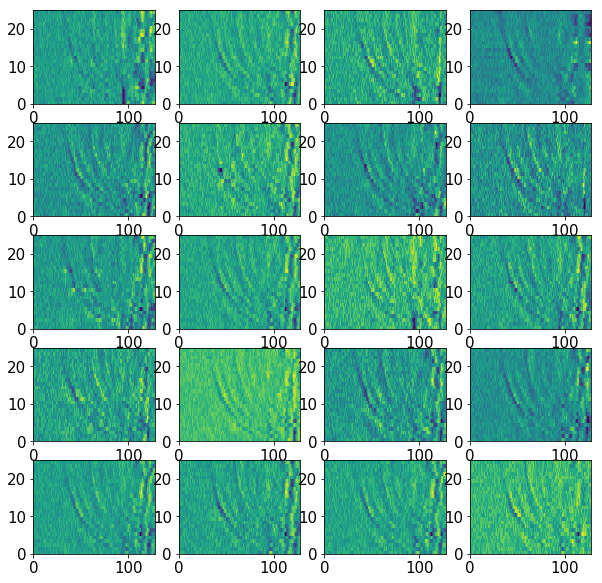

In [92]:
prior_sounds = w_sounds
# tmp = tmp / tmp.sum(0)

# tmp = (tmp.T/ tmp.sum(1)).T



# prior_sounds = (prior_sounds.T/ prior_sounds.sum(2).T).transpose([2,1,0])
# print(prior_sounds.shape)
# prior_sounds = (prior_sounds.transpose([1,0,2])/ prior_sounds.sum(1)).transpose([1,0,2])
print(prior_sounds.shape)


fig = plt.figure(figsize=(10,10))

axes = fig.subplots(5,4)

axes=axes.flatten()

for i in range(20):
    ax = axes[i]
    c = ax.pcolormesh(prior_sounds[i])

# plt.colorbar(c)




plt.show()

(20, 128)


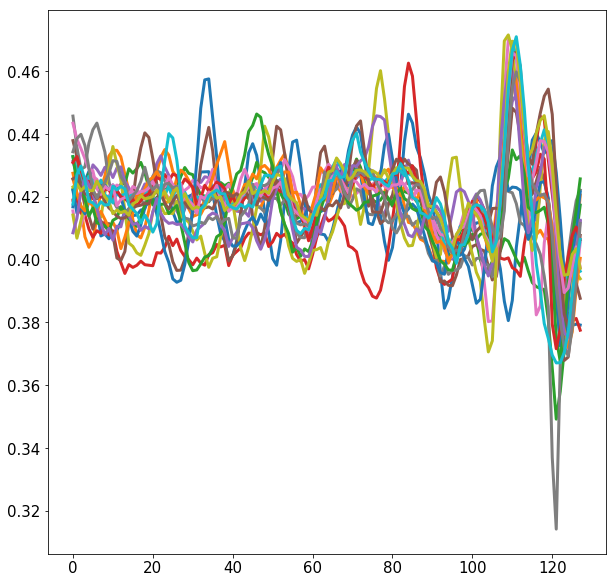

In [112]:
prior_sounds = w_sounds
# tmp = tmp / tmp.sum(0)

# tmp = (tmp.T/ tmp.sum(1)).T



# prior_sounds = (prior_sounds.T/ prior_sounds.sum(2).T).transpose([2,1,0])
# print(prior_sounds.shape)
# prior_sounds = (prior_sounds.transpose([1,0,2])/ prior_sounds.sum(1)).transpose([1,0,2])


plt.figure(figsize=(10,10))


prior_sounds = prior_sounds.mean(1)
print(prior_sounds.shape)

plt.plot(prior_sounds.T)
# plt.colorbar(c)
plt.show()

<Figure size 360x360 with 0 Axes>

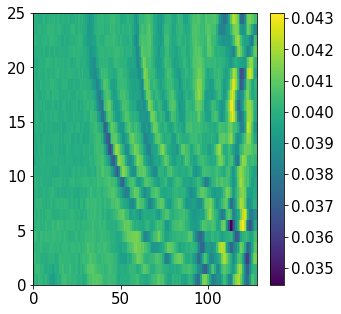

In [99]:
plt.figure(figsize=(5,5))

tmp = w



# tmp = (tmp.T/ tmp.sum(1)).T


# tmp = tmp / np.mean(tmp,axis=0)


tmp = (tmp.T/ tmp.sum(1)).T

tmp = tmp / tmp.sum(0)



plt.figure(figsize=(5,5))

plt.pcolormesh(tmp)

plt.colorbar()

w_ =tmp


In [121]:
#generate inputs
psd_all_c, psd_all_i = generateData.create_data(freq_bands, participant_number, snr, normalize, azimuth, time_window)

# Take only given elevations
input_c = psd_all_c[:, elevations, :]
input_i = psd_all_i[:, elevations, :]

# normalize inputs over frequencies
input_c = input_c / input_c.sum(2)[:,:,np.newaxis]
input_i = input_i / input_i.sum(2)[:,:,np.newaxis]

# Define neurons
# sounds_types = np.array([0,4,6,9,10])
sounds_types = np.arange(0,10)
# sounds_types = np.array([0])

n_sounds = len(sounds_types)
# elevations_angles = np.array([0])
elevations_angles = np.arange(0,25,1)
n_elevations = len(elevations_angles)

sigma = 3

q = np.zeros((n_sounds,n_elevations,len(ts),len(elevations)))

x_kernel = np.arange(freq_bands)

gauss_kernel = gauss(np.arange(-4*sigma,4*sigma),0,sigma)

results_bin = np.zeros((len(sounds_types),len(elevations_angles),3))

for i_sound,sound in enumerate(sounds_types):
    for i_ele,ele in enumerate(elevations_angles):

        in_i = input_i[sound,ele]
        in_c = input_c[sound,ele]

        # since the input does not change over time. We can do this calculation ouside the loop
        excitatory_in_p_i = convolve1d(out_thres(in_i),weights=gauss_kernel,axis=0,mode='reflect')
        excitatory_in_p_c = convolve1d(out_thres(in_c),weights=gauss_kernel,axis=0,mode='reflect')
        
        p_in_c = np.zeros((len(ts),freq_bands))
        p_in_i = np.zeros((len(ts),freq_bands))

        r_in_c = np.zeros((len(ts),freq_bands))
        r_in_i = np.zeros((len(ts),freq_bands))

        p_sum_i = np.zeros((len(ts),freq_bands))
        p_sum_c = np.zeros((len(ts),freq_bands))
        r_ipsi = np.zeros((len(ts),freq_bands))
        q_ele = np.zeros((len(ts),len(elevations)))
        
        
        w_tmp = w_ - (prior_sounds[sound]/2)
        w_tmp = (w_tmp.T/ w_tmp.sum(1)).T #sum over all frequencies, result has len=25 that is to ensure equal energy in each elevation
        w_tmp = w_tmp / w_tmp.sum(0)

        for t in range(0,len(ts)-1):
            
            
                        ## p_In_ipsi neuron
            # feed inputs ipsi inhibition
            p_in_i[ t+1,:] = p_in_i[ t,:] + dt* ode_p_in(p_in_i[t,:],excitatory_in_p_i)  

            ## r_In_ipsi neuron
            excitatory_in = out_thres(in_i)
            inhibitory_in = out_thres(p_in_i[ t,:])
            r_in_i[ t+1,:] = r_in_i[ t,:] + dt* ode_r_in(r_in_i[t,:],excitatory_in,inhibitory_in)   

            ## p_In_contra neuron
            # feed inputs ipsi inhibition
            p_in_c[ t+1,:] = p_in_c[ t,:] + dt* ode_p_in(p_in_c[t,:],excitatory_in_p_c)  

            ## r_In_contra neuron
            excitatory_in = out_thres(in_c)
            inhibitory_in = out_thres(p_in_c[ t,:])
            r_in_c[ t+1,:] = r_in_c[ t,:] + dt* ode_r_in(r_in_c[t,:],excitatory_in,inhibitory_in)   

            
            ## p_sum neurons
            excitatory_in = out_thres(r_in_i[ t,:]) 
            p_sum_i[ t+1,:] = p_sum_i[ t,:] + dt* ode_p_sum( p_sum_i[ t,:],excitatory_in)   
            
            excitatory_in = out_thres(r_in_c[ t,:]) 
            p_sum_c[ t+1,:] = p_sum_c[ t,:] + dt* ode_p_sum(p_sum_c[ t,:],excitatory_in)   
            
            
            ## r_ipsi neuron
            excitatory_in = out_thres(r_in_i[ t,:])+ out_thres(prior_sounds[sound])
            inhibitory_in =  out_thres(p_sum_c[ t,:]) + out_thres(p_sum_i[ t,:]) 
            r_ipsi[ t+1,:] = r_ipsi[ t,:] + dt* ode_r(r_ipsi[t,:],excitatory_in,inhibitory_in)   
            
             ## q readout neurons

            excitatory_in = np.dot(out_thres(r_ipsi[ t+1,:]), w_tmp.T)
            q_ele[t+1,:] = q_ele[t,:]+ dt* ode_q_sum(q_ele[t,:],excitatory_in)   

            if t%2900 == 0:
                clear_output(wait=True)
                print('Sound No: '+str(i_sound+1)+' of '+str(n_sounds)+'.\n  -> Elevation : '+str(i_ele+1)+' of '+str(n_elevations)+'.\n  -> Time : '+str(t))        
                
        dists = distance.cdist(w_, (r_ipsi[ t,:,np.newaxis]).T, metric='correlation')
        minimal_dist_ind = np.argmin(dists)
#         print('Real elevation: '+str(ele))
#         print('Correlation: '+str(minimal_dist_ind)+'  Neuron: '+ str(q[ -10,:].argmax()))
#         print()
#         plt.plot(q_ele[-1,:])
#         plt.plot(excitatory_in)
#         plt.show()
        
        ## save results
        # real location
        results_bin[i_sound,i_ele,0] = ele
        # correlation
        results_bin[i_sound,i_ele,1] = minimal_dist_ind
        # neuron activation
        results_bin[i_sound,i_ele,2] = q_ele[ -1,:].argmax()
             
#             if t%2950 == 0:

#                 print('Neuron: '+ str(excitatory_in.argmax()))
            
           

Sound No: 10 of 10.
  -> Elevation : 25 of 25.
  -> Time : 2900


<IPython.core.display.Javascript object>

Correlation:
Gain: -0.08, Bias: 11.62, , r^2: 0.01
Neuron:
Gain: 0.04, Bias: 3.06, , r^2: 0.01


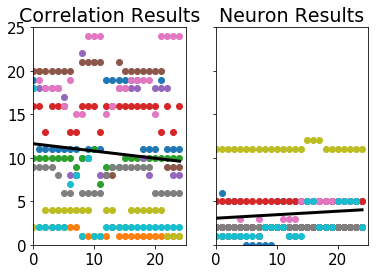

In [122]:
%notify
fig = plt.figure()

axes = fig.subplots(1,2,squeeze=False,sharex=True,sharey=True)

ax1 = axes[0,0]
ax1.set_title('Correlation Results')
for i_sound,sound in enumerate(sounds_types):
    ax1.scatter(results_bin[i_sound,:,0],results_bin[i_sound,:,1])

lr = LinearReg(np.squeeze(results_bin[:,:,0]),np.squeeze(results_bin[:,:,1]))
x,y = lr.get_fitted_line()
ax1.plot(x,y,linewidth = 3,color='black')
print('Correlation:')
lr.print_coefficients()
ax1.set_ylim([0,25])
ax1.set_xlim([0,25])

ax1 = axes[0,1]
ax1.set_title('Neuron Results')
for i_sound,sound in enumerate(sounds_types):
    ax1.scatter(results_bin[i_sound,:,0],results_bin[i_sound,:,2])
    
lr = LinearReg(np.squeeze(results_bin[:,:,0]),np.squeeze(results_bin[:,:,2]))
x,y = lr.get_fitted_line()
ax1.plot(x,y,linewidth = 3,color='black')
print('Neuron:')
lr.print_coefficients()
# ax1.set_ylim([0,25])
# ax1.set_xlim([0,25])
plt.show()

## Monaural Inputs 

In [109]:
#generate inputs
psd_all_c, psd_all_i = generateData.create_data(freq_bands, participant_number, snr, normalize, azimuth, time_window)

# Take only given elevations
input_c = psd_all_c[:, elevations, :]
input_i = psd_all_i[:, elevations, :]

# normalize inputs over frequencies
input_c = input_c / input_c.sum(2)[:,:,np.newaxis]
input_i = input_i / input_i.sum(2)[:,:,np.newaxis]

# Define neurons
# sounds_types = np.array([0,4,6,9,10])
sounds_types = np.arange(0,10)
# sounds_types = np.array([0])

n_sounds = len(sounds_types)
# elevations_angles = np.array([0])
elevations_angles = np.arange(0,25,1)
n_elevations = len(elevations_angles)

sigma = 3

q = np.zeros((n_sounds,n_elevations,len(ts),len(elevations)))

x_kernel = np.arange(freq_bands)

gauss_kernel = gauss(np.arange(-4*sigma,4*sigma),0,sigma)

results_mono = np.zeros((len(sounds_types),len(elevations_angles),3))

for i_sound,sound in enumerate(sounds_types):
    for i_ele,ele in enumerate(elevations_angles):

        in_i = input_i[sound,ele]
        in_c = input_c[sound,ele]
        
        # Contralateral input is zero
        in_c = np.ones(in_c.shape) *0.1

        # since the input does not change over time. We can do this calculation ouside the loop
        excitatory_in_p_i = convolve1d(out_thres(in_i),weights=gauss_kernel,axis=0,mode='reflect')
        excitatory_in_p_c = convolve1d(out_thres(in_c),weights=gauss_kernel,axis=0,mode='reflect')
        
        p_in_c = np.zeros((len(ts),freq_bands))
        p_in_i = np.zeros((len(ts),freq_bands))

        r_in_c = np.zeros((len(ts),freq_bands))
        r_in_i = np.zeros((len(ts),freq_bands))

        p_sum_i = np.zeros((len(ts),freq_bands))
        p_sum_c = np.zeros((len(ts),freq_bands))
        r_ipsi = np.zeros((len(ts),freq_bands))
        q_ele = np.zeros((len(ts),len(elevations)))
                
        w_tmp = w_ - prior_sounds[sound]
        w_tmp = (w_tmp.T/ w_tmp.sum(1)).T #sum over all frequencies, result has len=25 that is to ensure equal energy in each elevation


        for t in range(0,len(ts)-1):
            
            
                        ## p_In_ipsi neuron
            # feed inputs ipsi inhibition
            p_in_i[ t+1,:] = p_in_i[ t,:] + dt* ode_p_in(p_in_i[t,:],excitatory_in_p_i)  

            ## r_In_ipsi neuron
            excitatory_in = out_thres(in_i)
            inhibitory_in = out_thres(p_in_i[ t,:])
            r_in_i[ t+1,:] = r_in_i[ t,:] + dt* ode_r_in(r_in_i[t,:],excitatory_in,inhibitory_in)   

            ## p_In_contra neuron
            # feed inputs ipsi inhibition
            p_in_c[ t+1,:] = p_in_c[ t,:] + dt* ode_p_in(p_in_c[t,:],excitatory_in_p_c)  

            ## r_In_contra neuron
            excitatory_in = out_thres(in_c)
            inhibitory_in = out_thres(p_in_c[ t,:])
            r_in_c[ t+1,:] = r_in_c[ t,:] + dt* ode_r_in(r_in_c[t,:],excitatory_in,inhibitory_in)   

            
            ## p_sum neurons
            excitatory_in = out_thres(r_in_i[ t,:]) 
            p_sum_i[ t+1,:] = p_sum_i[ t,:] + dt* ode_p_sum( p_sum_i[ t,:],excitatory_in)   
            
            excitatory_in = out_thres(r_in_c[ t,:]) 
            p_sum_c[ t+1,:] = p_sum_c[ t,:] + dt* ode_p_sum(p_sum_c[ t,:],excitatory_in)   
            
            
            ## r_ipsi neuron
            excitatory_in = out_thres(r_in_i[ t,:])
            inhibitory_in =  out_thres(p_sum_c[ t,:]) + out_thres(p_sum_i[ t,:]) #<-- not necessary
            r_ipsi[ t+1,:] = r_ipsi[ t,:] + dt* ode_r(r_ipsi[t,:],excitatory_in,inhibitory_in)   
            
             ## q readout neurons
            excitatory_in = np.dot(out_thres(r_ipsi[ t+1,:]), w_tmp.T)
            q_ele[t+1,:] = q_ele[t,:]+ dt* ode_q_sum(q_ele[t,:],excitatory_in)   
            if t%2900 == 0:
                clear_output(wait=True)
                print('Sound No: '+str(i_sound+1)+' of '+str(n_sounds)+'.\n  -> Elevation : '+str(i_ele+1)+' of '+str(n_elevations)+'.\n  -> Time : '+str(t))        
                
        dists = distance.cdist(w_, (r_ipsi[ t,:,np.newaxis]).T, metric='correlation')
        minimal_dist_ind = np.argmin(dists)

        
#         clear_output(wait=True)

#         plt.figure(figsize=(5,5))
        
# #         plt.plot(r_ipsi[-1,:])
#         plt.plot(q_ele[-1,:])
# #         plt.plot(excitatory_in)
# #         plt.ylim([0.7,0.8])
#         plt.show()

        ## save results
        # real location
        results_mono[i_sound,i_ele,0] = ele
        # correlation
        results_mono[i_sound,i_ele,1] = minimal_dist_ind
        # neuron activation
        results_mono[i_sound,i_ele,2] = q_ele[ -1,:].argmax()
             

            
           

Sound No: 10 of 10.
  -> Elevation : 25 of 25.
  -> Time : 2900


<IPython.core.display.Javascript object>

Correlation:
Gain: 0.28, Bias: 4.05, , r^2: 0.09
Neuron:
Gain: -0.27, Bias: 16.53, , r^2: 0.08


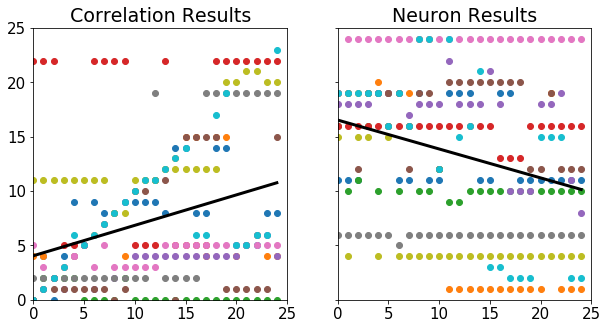

In [110]:
%notify
fig = plt.figure(figsize=(10,5))

axes = fig.subplots(1,2,squeeze=False,sharex=True,sharey=True)

ax1 = axes[0,0]
ax1.set_title('Correlation Results')
for i_sound,sound in enumerate(sounds_types):
    ax1.scatter(results_mono[i_sound,:,0],results_mono[i_sound,:,1])

lr = LinearReg(np.squeeze(results_mono[:,:,0]),np.squeeze(results_mono[:,:,1]))
x,y = lr.get_fitted_line()
ax1.plot(x,y,linewidth = 3,color='black')
print('Correlation:')
lr.print_coefficients()
ax1.set_ylim([0,25])
ax1.set_xlim([0,25])

ax1 = axes[0,1]
ax1.set_title('Neuron Results')
for i_sound,sound in enumerate(sounds_types):
    ax1.scatter(results_mono[i_sound,:,0],results_mono[i_sound,:,2])
    
lr = LinearReg(np.squeeze(results_mono[:,:,0]),np.squeeze(results_mono[:,:,2]))
x,y = lr.get_fitted_line()
ax1.plot(x,y,linewidth = 3,color='black')
print('Neuron:')
lr.print_coefficients()
# ax1.set_ylim([0,25])
# ax1.set_xlim([0,25])
plt.show()

Monaural:
Gain: -0.27, Bias: 32.30, , r^2: 0.08
Binaural:
Gain: -0.36, Bias: 3.04, , r^2: 0.14


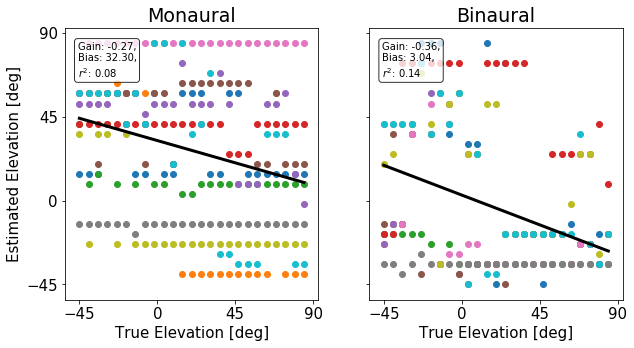

In [117]:
# scale the values

x_test_bin,y_test_bin = scale_v(results_bin[:,:,0],results_bin[:,:,2],25)
x_test_mono,y_test_mono = scale_v(results_mono[:,:,0],results_mono[:,:,2],25)


fig = plt.figure(figsize=(10,5))

axes = fig.subplots(1,2,squeeze=False,sharex=True,sharey=True)

ax1 = axes[0,0]
ax1.set_title('Monaural')
for i_sound,sound in enumerate(sounds_types):
    ax1.scatter(x_test_mono[i_sound,:],y_test_mono[i_sound,:])
    
lr = LinearReg(np.squeeze(x_test_mono),np.squeeze(y_test_mono))
x,y = lr.get_fitted_line()
ax1.plot(x,y,linewidth = 3,color='black')
print('Monaural:')
text_str = lr.print_coefficients()
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.8)

# place a text box in upper left in axes coords
ax1.text(0.05, 0.95, text_str, transform=ax1.transAxes, verticalalignment='top', bbox=props)

t = np.zeros(6)
t[0] = -55
t[1] = -45
t[2] = 0
t[3] = 45
t[4] = 90
t[5] = 100
ax1.set_xticks(t[1:-1])
ax1.set_yticks(t[1:-1])

ax1.set_ylabel('Estimated Elevation [deg]')
ax1.set_xlabel('True Elevation [deg]')


ax1 = axes[0,1]
ax1.set_title('Binaural')
for i_sound,sound in enumerate(sounds_types):
    ax1.scatter(x_test_bin[i_sound,:],y_test_bin[i_sound,:])
    
lr = LinearReg(np.squeeze(x_test_bin[:,:]),np.squeeze(y_test_bin[:,:]))
x,y = lr.get_fitted_line()
ax1.plot(x,y,linewidth = 3,color='black')
print('Binaural:')

text_str = lr.print_coefficients()
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.8)

# place a text box in upper left in axes coords
ax1.text(0.05, 0.95, text_str, transform=ax1.transAxes, verticalalignment='top', bbox=props)

# ax1.set_ylim([0,25])
# ax1.set_xlim([0,25])



ax1.set_xlabel('True Elevation [deg]')

ax1.set_xticks(t[1:-1])


# plt.savefig("neuron_results_correlation.pdf", dpi=300)
# plt.savefig("neuron_results_correlation.svg", dpi=300)


plt.show()

In [81]:
def scale_v(x_test, y_test, n_elevations):
    a = x_test /  n_elevations
    a = a * (n_elevations - 1) * 5.625 - 45
    x_test = a

    a = y_test /  n_elevations
    a = a * (n_elevations - 1) * 5.625 - 45
    y_test = a

    return x_test, y_test